In [1]:
!pip install tensorflow==2.7.0
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.4
    Uninstalling tensorflow-2.6.4:
      Successfully uninstalled tensorflow-2.6.4
ERROR: pip's dependency resolver does not currently take into account all t

In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import pandas as pd
import numpy as np
import sklearn
import matplotlib as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Embedding, LSTM
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import math
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

/kaggle/input/predicting-the-sales-of-products-of-a-retail-chain/sample_submission.csv
/kaggle/input/predicting-the-sales-of-products-of-a-retail-chain/train_data.csv
/kaggle/input/predicting-the-sales-of-products-of-a-retail-chain/date_to_week_id_map.csv
/kaggle/input/predicting-the-sales-of-products-of-a-retail-chain/test_data.csv
/kaggle/input/predicting-the-sales-of-products-of-a-retail-chain/product_prices.csv


2023-01-06 18:37:26.250902: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-01-06 18:37:26.250945: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Data Collection

In [3]:
train = pd.read_csv('/kaggle/input/predicting-the-sales-of-products-of-a-retail-chain/train_data.csv')

print(train.head())

import datetime
lag_size = 28
print('Forecast lag size: ', lag_size)

         date  product_identifier  department_identifier  \
0  2012-01-01                  74                     11   
1  2012-01-01                 337                     11   
2  2012-01-01                 423                     12   
3  2012-01-01                 432                     12   
4  2012-01-01                 581                     21   

          category_of_product  outlet        state  sales  
0                      others     111  Maharashtra      0  
1                      others     111  Maharashtra      1  
2                      others     111  Maharashtra      0  
3                      others     111  Maharashtra      0  
4  fast_moving_consumer_goods     111  Maharashtra      0  
Forecast lag size:  28


Data Clearning

In [4]:
train = train[(train['date'] >= '2012-01-01')]
train_gp = train.sort_values('date').groupby(['product_identifier', 'outlet', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['product_identifier', 'outlet', 'date', 'sales']
train_gp.head()

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(np.array(train_gp['sales']).reshape(-1,1))
normalized = scaler.transform(np.array(train_gp['sales']).reshape(-1,1))
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
train_gp['sales'] = normalized.copy()

Min: 0.000000, Max: 293.000000


Transform the data into a time series problem

In [5]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Determine the window and lag size

In [6]:
window = 30
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,product_identifier(t-30),outlet(t-30),sales(t-30),product_identifier(t-29),outlet(t-29),sales(t-29),product_identifier(t-28),outlet(t-28),sales(t-28),product_identifier(t-27),...,sales(t-2),product_identifier(t-1),outlet(t-1),sales(t-1),product_identifier(t),outlet(t),sales(t),product_identifier(t+28),outlet(t+28),sales(t+28)
30,74.0,111.0,0.000000,74.0,111.0,0.000000,74.0,111.0,0.003413,74.0,...,0.000000,74.0,111.0,0.010239,74,111,0.000000,74.0,111.0,0.000000
31,74.0,111.0,0.000000,74.0,111.0,0.003413,74.0,111.0,0.000000,74.0,...,0.010239,74.0,111.0,0.000000,74,111,0.003413,74.0,111.0,0.003413
32,74.0,111.0,0.003413,74.0,111.0,0.000000,74.0,111.0,0.000000,74.0,...,0.000000,74.0,111.0,0.003413,74,111,0.003413,74.0,111.0,0.000000
33,74.0,111.0,0.000000,74.0,111.0,0.000000,74.0,111.0,0.000000,74.0,...,0.003413,74.0,111.0,0.003413,74,111,0.000000,74.0,111.0,0.000000
34,74.0,111.0,0.000000,74.0,111.0,0.000000,74.0,111.0,0.000000,74.0,...,0.003413,74.0,111.0,0.000000,74,111,0.000000,74.0,111.0,0.003413


Transform the data into window t-Number

In [7]:
last_product_identifier = 'product_identifier(t-%d)' % window
last_outlet = 'outlet(t-%d)' % window
series = series[(series['outlet(t)'] == series[last_outlet])]
series = series[(series['product_identifier(t)'] == series[last_product_identifier])]
series.head()

,product_identifier(t-30),outlet(t-30),sales(t-30),product_identifier(t-29),outlet(t-29),sales(t-29),product_identifier(t-28),outlet(t-28),sales(t-28),product_identifier(t-27),...,sales(t-2),product_identifier(t-1),outlet(t-1),sales(t-1),product_identifier(t),outlet(t),sales(t),product_identifier(t+28),outlet(t+28),sales(t+28)
30,74.0,111.0,0.000000,74.0,111.0,0.000000,74.0,111.0,0.003413,74.0,...,0.000000,74.0,111.0,0.010239,74,111,0.000000,74.0,111.0,0.000000
31,74.0,111.0,0.000000,74.0,111.0,0.003413,74.0,111.0,0.000000,74.0,...,0.010239,74.0,111.0,0.000000,74,111,0.003413,74.0,111.0,0.003413
32,74.0,111.0,0.003413,74.0,111.0,0.000000,74.0,111.0,0.000000,74.0,...,0.000000,74.0,111.0,0.003413,74,111,0.003413,74.0,111.0,0.000000
33,74.0,111.0,0.000000,74.0,111.0,0.000000,74.0,111.0,0.000000,74.0,...,0.003413,74.0,111.0,0.003413,74,111,0.000000,74.0,111.0,0.000000
34,74.0,111.0,0.000000,74.0,111.0,0.000000,74.0,111.0,0.000000,74.0,...,0.003413,74.0,111.0,0.000000,74,111,0.000000,74.0,111.0,0.003413


Drop columns not used

In [8]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['product_identifier', 'outlet']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['product_identifier', 'outlet']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['product_identifier(t)', 'outlet(t)'], axis=1, inplace=True)
series.head()

,sales(t-30),sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t),sales(t+28)
30,0.000000,0.000000,0.003413,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.003413,...,0.000000,0.000000,0.000000,0.003413,0.000000,0.006826,0.000000,0.010239,0.000000,0.000000
31,0.000000,0.003413,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.003413,0.000000,...,0.000000,0.000000,0.003413,0.000000,0.006826,0.000000,0.010239,0.000000,0.003413,0.003413
32,0.003413,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.003413,0.000000,0.006826,...,0.000000,0.003413,0.000000,0.006826,0.000000,0.010239,0.000000,0.003413,0.003413,0.000000
33,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.003413,0.000000,0.006826,0.006826,...,0.003413,0.000000,0.006826,0.000000,0.010239,0.000000,0.003413,0.003413,0.000000,0.000000
34,0.000000,0.000000,0.000000,0.0,0.0,0.003413,0.000000,0.006826,0.006826,0.000000,...,0.000000,0.006826,0.000000,0.010239,0.000000,0.003413,0.003413,0.000000,0.000000,0.003413


Split data in Train and Validation

In [9]:
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

In [10]:
X_train, X_rem, Y_train, Y_rem = train_test_split(series, labels.values, test_size=0.4, random_state=4)
print('Train set shape', X_train.shape)
print('Y Train set shape', Y_train.shape)

X_test, X_valid, Y_test, Y_valid = train_test_split(X_rem, Y_rem, test_size=0.5, random_state=4)

print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (227983, 31)
Y Train set shape (227983,)
Train set shape (227983, 31)
Validation set shape (75995, 31)


,sales(t-30),sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
374424,0.000000,0.003413,0.003413,0.000000,0.003413,0.013652,0.006826,0.020478,0.017065,0.006826,...,0.003413,0.006826,0.010239,0.006826,0.000000,0.000000,0.000000,0.000000,0.010239,0.003413
54611,0.000000,0.003413,0.000000,0.000000,0.000000,0.000000,0.003413,0.003413,0.000000,0.003413,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.006826,0.006826,0.000000,0.000000,0.010239
379968,0.000000,0.000000,0.006826,0.010239,0.000000,0.000000,0.003413,0.000000,0.000000,0.010239,...,0.006826,0.000000,0.013652,0.010239,0.000000,0.000000,0.000000,0.003413,0.017065,0.003413
106751,0.020478,0.020478,0.020478,0.010239,0.013652,0.027304,0.010239,0.006826,0.010239,0.034130,...,0.013652,0.003413,0.010239,0.006826,0.017065,0.023891,0.020478,0.023891,0.013652,0.020478
324622,0.000000,0.000000,0.000000,0.006826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003413,0.000000,0.000000,0.000000,0.000000,0.000000,0.006826,0.000000,0.000000,0.003413


Transform train and validation data into series

In [11]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (227983, 31, 1)
Validation set shape (75995, 31, 1)


Model tunning

In [12]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV

def create_model():
 # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2]), dropout=0.2))
    model.add(tf.keras.layers.Dense(1))
 # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

# define the grid search parameters
batch_size = [30]
epochs = [10, 20]
param_grid = dict(batch_size=batch_size, epochs=epochs)
model_new = KerasClassifier(model=create_model, verbose=2)
grid = HalvingGridSearchCV(estimator=model_new, param_grid=param_grid,cv=5, scoring='accuracy')

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_valid_encoded = label_encoder.fit_transform(Y_valid)

grid_result = grid.fit(X_train_series, Y_train_encoded, validation_data=(X_valid_series, Y_valid_encoded))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
2023-01-06 18:37:34.779834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-01-06 18:37:34.779887: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-06 18:37:34.779922: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (8f4e97113786): /proc/driver/nvidia/version does not exist
2023-01-06 18:37:34.780196: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with one

Epoch 1/10
6080/6080 - 83s - loss: 11.8148 - accuracy: 0.3061 - val_loss: 10.1374 - val_accuracy: 0.1588 - 83s/epoch - 14ms/step
Epoch 2/10
6080/6080 - 80s - loss: 10.1541 - accuracy: 0.4437 - val_loss: 9.1719 - val_accuracy: 0.1588 - 80s/epoch - 13ms/step
Epoch 3/10
6080/6080 - 80s - loss: 9.3871 - accuracy: 0.4550 - val_loss: 8.6027 - val_accuracy: 0.5235 - 80s/epoch - 13ms/step
Epoch 4/10
6080/6080 - 81s - loss: 8.4224 - accuracy: 0.4475 - val_loss: 8.3228 - val_accuracy: 0.5608 - 81s/epoch - 13ms/step
Epoch 5/10
6080/6080 - 81s - loss: 8.1640 - accuracy: 0.4413 - val_loss: 8.0157 - val_accuracy: 0.5692 - 81s/epoch - 13ms/step
Epoch 6/10
6080/6080 - 81s - loss: 7.9172 - accuracy: 0.4151 - val_loss: 7.8062 - val_accuracy: 0.5951 - 81s/epoch - 13ms/step
Epoch 7/10
6080/6080 - 81s - loss: 7.6136 - accuracy: 0.4404 - val_loss: 7.5163 - val_accuracy: 0.3837 - 81s/epoch - 13ms/step
Epoch 8/10
6080/6080 - 81s - loss: 7.6208 - accuracy: 0.4481 - val_loss: 7.9993 - val_accuracy: 0.6069 - 81s

Build the LSTM Model

In [13]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.summary()
model_lstm.compile(optimizer='adam', loss='mse')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


Train the lstm model with the best parameters

In [14]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=100, verbose=2, batch_size=30)

Epoch 1/100
7600/7600 - 104s - loss: 1.0843e-04 - val_loss: 1.0805e-04 - 104s/epoch - 14ms/step
Epoch 2/100
7600/7600 - 105s - loss: 1.0661e-04 - val_loss: 1.0727e-04 - 105s/epoch - 14ms/step
Epoch 3/100
7600/7600 - 104s - loss: 1.0552e-04 - val_loss: 1.0757e-04 - 104s/epoch - 14ms/step
Epoch 4/100
7600/7600 - 103s - loss: 1.0533e-04 - val_loss: 1.1026e-04 - 103s/epoch - 14ms/step
Epoch 5/100
7600/7600 - 102s - loss: 1.0402e-04 - val_loss: 1.0957e-04 - 102s/epoch - 13ms/step
Epoch 6/100
7600/7600 - 100s - loss: 1.0420e-04 - val_loss: 1.0696e-04 - 100s/epoch - 13ms/step
Epoch 7/100
7600/7600 - 102s - loss: 1.0383e-04 - val_loss: 1.0616e-04 - 102s/epoch - 13ms/step
Epoch 8/100
7600/7600 - 100s - loss: 1.0479e-04 - val_loss: 1.0531e-04 - 100s/epoch - 13ms/step
Epoch 9/100
7600/7600 - 99s - loss: 1.0427e-04 - val_loss: 1.0817e-04 - 99s/epoch - 13ms/step
Epoch 10/100
7600/7600 - 99s - loss: 1.0366e-04 - val_loss: 1.0577e-04 - 99s/epoch - 13ms/step
Epoch 11/100
7600/7600 - 100s - loss: 1.034

Performance measurement

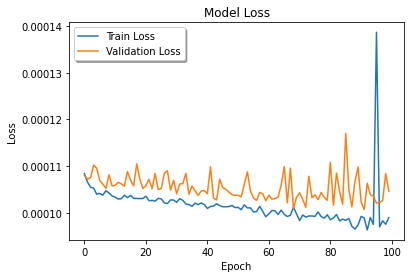

In [15]:
import matplotlib.pyplot as plt 
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], fancybox=True, shadow=True)
plt.show()

Performance in validation set

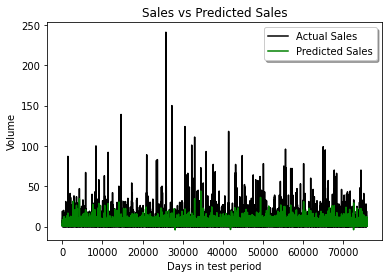

In [16]:
# change back to min max
predicted_sales = model_lstm.predict(X_valid_series)

plt.plot(scaler.inverse_transform(np.array(Y_valid).reshape(-1,1)).flatten(), color='black', label=f"Actual Sales")
plt.plot(scaler.inverse_transform(np.array(predicted_sales).reshape(-1,1)).flatten(), color= 'green', label="Predicted Sales")
plt.title("Sales vs Predicted Sales")
plt.xlabel("Days in test period")
plt.ylabel("Volume")
plt.legend(fancybox=True, shadow=True)
plt.show()

RSME and MAPE

In [17]:
def smape(a, f):
    return 1/len(a) * np.sum(2*np.abs(f-a)/(np.abs(a)+np.abs(f))*100)
print("{:.4}%".format(smape(scaler.inverse_transform(np.array(Y_valid).reshape(-1,1)).flatten(),scaler.inverse_transform(np.array(predicted_sales).reshape(-1,1)).flatten())))

148.6%


In [18]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(scaler.inverse_transform(np.array(Y_valid).reshape(-1,1)).flatten(),scaler.inverse_transform(np.array(predicted_sales).reshape(-1,1)).flatten()))

8.985306105659456


Epoch Batch

10 60 138.0% 29.166570980057436 with dropout

50 10 142.7% 29.5902925577321

50 60 139.8% 29.875080899034234

100 10 152.5% 8.927442666849982

10 30 159.0% 7.943576742473504

20 30 159.7% 7.812799257608862

50 30 167.6% 7.98768476096198

Performance in Test data

In [19]:
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Test shape', X_test_series.shape)
print('Test shape', Y_test.shape)

Test shape (75994, 31, 1)
Test shape (75994,)


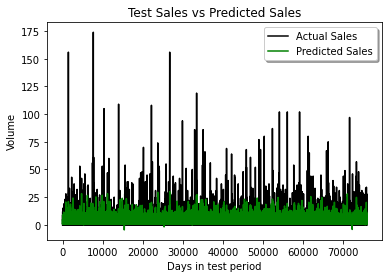

In [20]:
predicted_sales_test = model_lstm.predict(X_test_series)

plt.plot(scaler.inverse_transform(np.array(Y_test).reshape(-1,1)).flatten(), color='black', label=f"Actual Sales")
plt.plot(scaler.inverse_transform(np.array(predicted_sales_test).reshape(-1,1)).flatten(), color= 'green', label="Predicted Sales")
plt.title("Test Sales vs Predicted Sales")
plt.xlabel("Days in test period")
plt.ylabel("Volume")
plt.legend(fancybox=True, shadow=True)
plt.show()

In [21]:
print("{:.4}%".format(smape(scaler.inverse_transform(np.array(Y_test).reshape(-1,1)).flatten(),scaler.inverse_transform(np.array(predicted_sales_test).reshape(-1,1)).flatten())))

148.2%


In [22]:
print(mean_squared_error(scaler.inverse_transform(np.array(Y_test).reshape(-1,1)).flatten(),scaler.inverse_transform(np.array(predicted_sales_test).reshape(-1,1)).flatten()))

8.243981858219412


Test Performance

10 30 159.0% 8.672678367259874

10 60 134.1% 32.02048404856427  with dropout

20 30 159.7% 8.57719643359611

50 60 135.9% 32.79656928199366

50 10 138.7% 32.48762213712006
50 30 167.5% 8.7616621717911